In [1]:
# If needed (Colab / fresh env):
# !pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install -U tqdm numpy

import os, time, math, random
from dataclasses import dataclass
from pathlib import Path

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision.transforms import v2 as T 
from torchvision.models import resnet101, ResNet101_Weights

In [2]:
@dataclass
class CFG:
    data_root: str = "./stanford_cars"
    num_classes: int = 196  # Stanford Cars has 196 classes
    img_size: int = 320

    use_bbox: bool = True  # set True to train/eval on bbox crops

    epochs: int = 20
    batch_size: int = 40
    num_workers: int = 4

    lr: float = 3e-4
    weight_decay: float = 0.1
    label_smoothing: float = 0.1

    use_amp: bool = True
    grad_clip_norm: float = 1.0

    # cosine schedule
    warmup_epochs: int = 1
    min_lr: float = 1e-6

    seed: int = 42
    save_dir: str = "./checkpoints"
    run_name: str = "resnet101_stanfordcars_imagenet1k"
    model_name: str = "resnet101"

cfg = CFG()

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(cfg.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

os.makedirs(cfg.save_dir, exist_ok=True)


Device: cuda


In [3]:
from data_utils import load_car_annotations
train_df, test_df, id_to_name = load_car_annotations(cfg.data_root)
train_df.head()

train rows: 8144 with paths: 8144
test rows: 8041 with paths: 8041


file_name   x1   y1    x2    y2  class_id  \
0  00001.jpg   39  116   569   375        14   
1  00002.jpg   36  116   868   587         3   
2  00003.jpg   85  109   601   381        91   
3  00004.jpg  621  393  1484  1096       134   
4  00005.jpg   14   36   133    99       106   

                            class_name  \
0                  Audi TTS Coupe 2012   
1                  Acura TL Sedan 2012   
2           Dodge Dakota Club Cab 2007   
3     Hyundai Sonata Hybrid Sedan 2012   
4  Ford F-450 Super Duty Crew Cab 2012   

                                            filepath  
0  stanford_cars\car_data\car_data\train\Audi TTS...  
1  stanford_cars\car_data\car_data\train\Acura TL...  
2  stanford_cars\car_data\car_data\train\Dodge Da...  
3  stanford_cars\car_data\car_data\train\Hyundai ...  
4  stanford_cars\car_data\car_data\train\Ford F-4...

Train: Plymouth Neon Coupe 1999 | full: 1012x759px | bbox: 854x439px | square-from-full: 854x854px (S=854) | pad(LR/TB)=0,0/61,62 | file: stanford_cars\car_data\car_data\train\Plymouth Neon Coupe 1999\07438.jpg
Train: Honda Odyssey Minivan 2012 | full: 600x338px | bbox: 480x226px | square-from-full: 480x480px (S=480) | pad(LR/TB)=0,0/71,71 | file: stanford_cars\car_data\car_data\train\Honda Odyssey Minivan 2012\00484.jpg
Train: Aston Martin Virage Convertible 2012 | full: 628x418px | bbox: 608x293px | square-from-full: 608x608px (S=608) | pad(LR/TB)=0,0/95,95 | file: stanford_cars\car_data\car_data\train\Aston Martin Virage Convertible 2012\07599.jpg
Test: Hyundai Elantra Touring Hatchback 2012 | full: 640x480px | bbox: 444x280px | square-from-full: 444x444px (S=444) | pad(LR/TB)=0,0/0,0 | file: stanford_cars\car_data\car_data\test\Hyundai Elantra Touring Hatchback 2012\02836.jpg
Test: Ferrari 458 Italia Coupe 2012 | full: 1280x960px | bbox: 1144x423px | square-from-full: 1144x1144px (

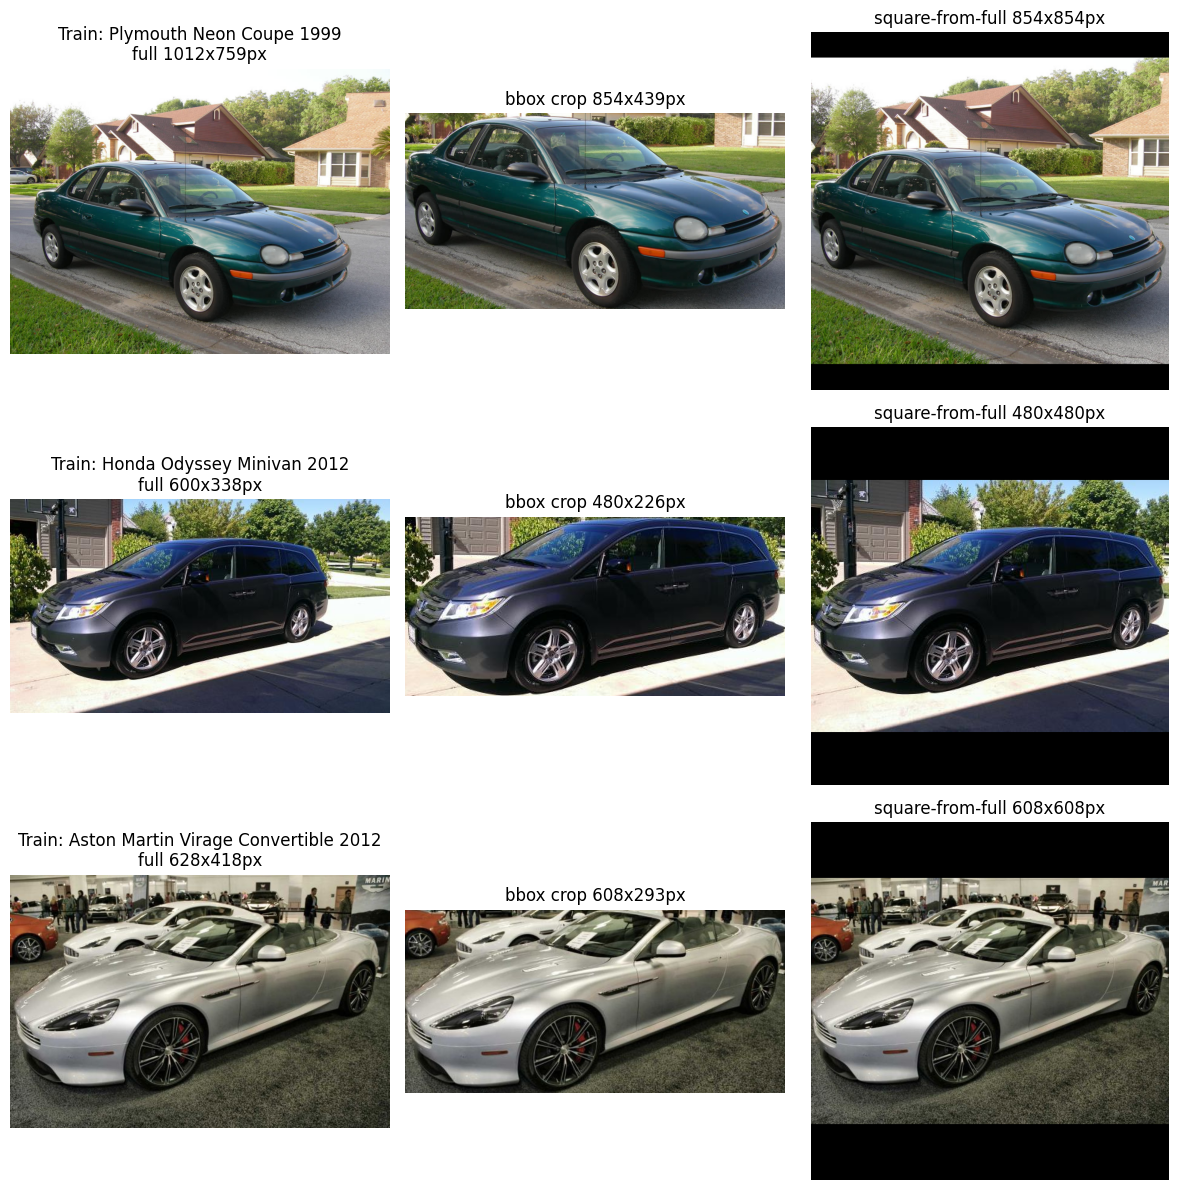

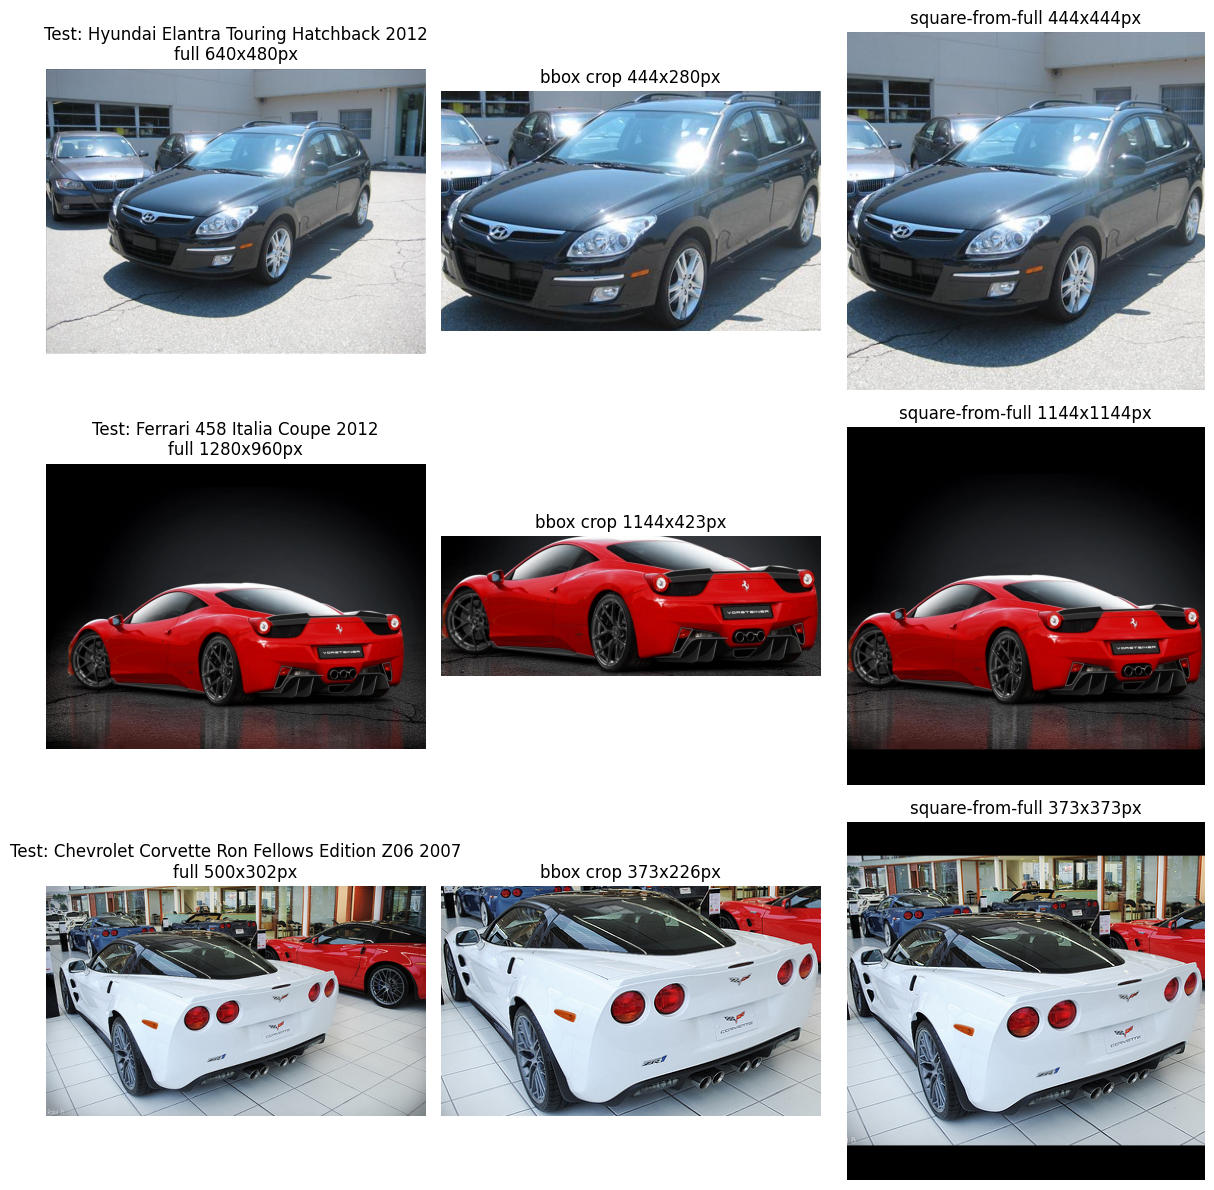

In [4]:
from data_utils import show_full_and_crop
show_full_and_crop(train_df, n=3, seed=42, title_prefix="Train: ")
show_full_and_crop(test_df, n=3, seed=42, title_prefix="Test: ")

In [5]:
# We'll build our own to add augmentation; keep ImageNet mean/std.
weights = ResNet101_Weights.IMAGENET1K_V1

from data_utils import get_mean_std_from_weights
mean, std = get_mean_std_from_weights(weights)
print("mean:", mean, "std:", std)


train_tfms = T.Compose([
    T.Resize((cfg.img_size, cfg.img_size)),
    T.RandomApply([T.ColorJitter(0.15, 0.15, 0.05, 0.05)], p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    T.ToImage(),                              # Tensor/PIL/ndarray -> TVTensor Image
    T.ToDtype(torch.float32, scale=True),     # uint8 -> float in [0,1]
    T.Normalize(mean=mean, std=std),
])

test_tfms = T.Compose([
    T.Resize((cfg.img_size, cfg.img_size)),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=mean, std=std),
])

mean: (0.485, 0.456, 0.406) std: (0.229, 0.224, 0.225)


In [6]:
from cars_dataset import CarsCsvDataset

from data_utils import df_to_arrays
train_files, train_boxes, train_labels = df_to_arrays(train_df)
test_files, test_boxes, test_labels = df_to_arrays(test_df)

train_ds = CarsCsvDataset(train_files, train_boxes, train_labels, transform=train_tfms,
                          crop_mode="square_from_full", square_margin=0.10)
test_ds = CarsCsvDataset(test_files, test_boxes, test_labels, transform=test_tfms, crop_mode="square_from_full", square_margin=0.10)

print("Train:", len(train_ds), "Test:", len(test_ds))

loader_kwargs = dict(
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=True,
    drop_last=True,
)
if cfg.num_workers > 0:
    loader_kwargs.update(persistent_workers=True, prefetch_factor=4)

train_loader = DataLoader(train_ds, **loader_kwargs)

test_loader_kwargs = dict(
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=True,
    drop_last=False,
)
if cfg.num_workers > 0:
    test_loader_kwargs.update(persistent_workers=True, prefetch_factor=4)

test_loader = DataLoader(test_ds, **test_loader_kwargs)


Train: 8144 Test: 8041


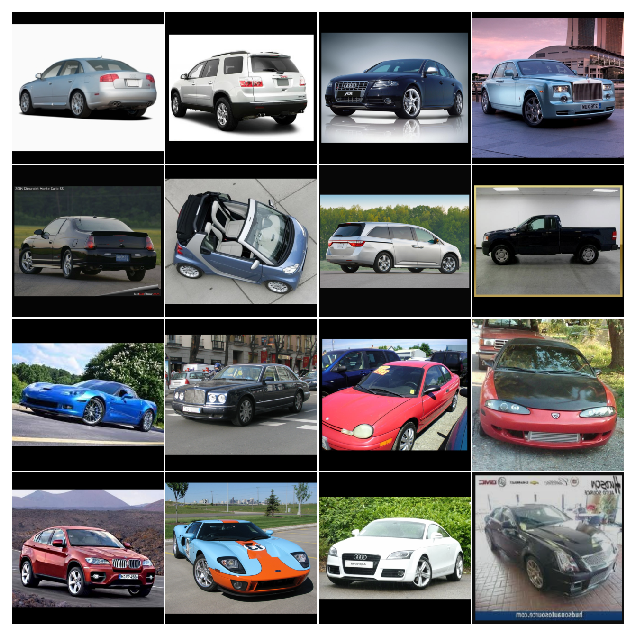

In [7]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# put the same mean/std you used in transforms.Normalize(...)
mean_t = torch.tensor(mean)
std_t = torch.tensor(std)

def unnormalize_batch(x, mean_t, std_t):
    # x: [B,C,H,W]
    mean_t = mean_t[None, :, None, None].to(x.device)
    std_t  = std_t[None, :, None, None].to(x.device)
    return (x * std_t + mean_t).clamp(0, 1)

batch = next(iter(train_loader))
images, labels = batch if isinstance(batch, (tuple, list)) else (batch["image"], batch.get("label"))

images_vis = unnormalize_batch(images, mean_t, std_t)

grid = make_grid(
    images_vis[:16],
    nrow=4,
    padding=4,        # border thickness (pixels)
    pad_value=1.0     # border color (1.0 = white, 0.0 = black)
)

plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu(), interpolation="nearest")
plt.axis("off")
plt.show()

In [8]:
model = resnet101(weights=weights)

# Replace classifier head for 196 classes
# torchvision ResNet classifier is: model.fc = Linear
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, cfg.num_classes)

model = model.to(device)

sum(p.numel() for p in model.parameters()) / 1e6

42.901764

In [9]:
criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

def lr_at_epoch(epoch_float: float):
    """epoch_float can be e.g. epoch + step/steps_per_epoch."""
    # Warmup
    if epoch_float < cfg.warmup_epochs:
        return cfg.lr * (epoch_float / max(cfg.warmup_epochs, 1e-8))
    # Cosine decay
    progress = (epoch_float - cfg.warmup_epochs) / max(cfg.epochs - cfg.warmup_epochs, 1)
    progress = min(max(progress, 0.0), 1.0)
    cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
    return cfg.min_lr + (cfg.lr - cfg.min_lr) * cosine

scaler = torch.amp.GradScaler(enabled=(cfg.use_amp and device.type == "cuda"))

In [10]:
from train_utils import train_one_epoch, evaluate, save_checkpoint
import gc

def build_transforms(img_size, mean, std):
    train_tfms = T.Compose([
        T.Resize((img_size, img_size)),
        T.RandomApply([T.ColorJitter(0.15, 0.15, 0.05, 0.05)], p=0.5),
        T.RandomHorizontalFlip(p=0.5),
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(mean=mean, std=std),
    ])

    test_tfms = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(mean=mean, std=std),
    ])

    return train_tfms, test_tfms


def build_loaders(train_df, test_df, train_tfms, test_tfms):
    from data_utils import df_to_arrays
    from cars_dataset import CarsCsvDataset

    train_files, train_boxes, train_labels = df_to_arrays(train_df)
    test_files, test_boxes, test_labels = df_to_arrays(test_df)

    train_ds = CarsCsvDataset(
        train_files, train_boxes, train_labels, transform=train_tfms,
        crop_mode="square_from_full", square_margin=0.10
    )
    test_ds = CarsCsvDataset(
        test_files, test_boxes, test_labels, transform=test_tfms,
        crop_mode="square_from_full", square_margin=0.10
    )

    loader_kwargs = dict(
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    if cfg.num_workers > 0:
        loader_kwargs.update(persistent_workers=True, prefetch_factor=4)

    train_loader = DataLoader(train_ds, **loader_kwargs)

    test_loader_kwargs = dict(
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=True,
        drop_last=False,
    )
    if cfg.num_workers > 0:
        test_loader_kwargs.update(persistent_workers=True, prefetch_factor=4)

    test_loader = DataLoader(test_ds, **test_loader_kwargs)

    return train_loader, test_loader


summaries = []

for img_size in [224, 320]:
    cfg.img_size = img_size
    cfg.run_name = f"resnet101_{img_size}"

    train_tfms, test_tfms = build_transforms(cfg.img_size, mean, std)
    train_loader, test_loader = build_loaders(train_df, test_df, train_tfms, test_tfms)

    model = resnet101(weights=weights)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, cfg.num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scaler = torch.amp.GradScaler(enabled=(cfg.use_amp and device.type == "cuda"))

    best_top1 = 0.0
    best_path = os.path.join(cfg.save_dir, f"{cfg.run_name}_best.pth")
    last_path = os.path.join(cfg.save_dir, f"{cfg.run_name}_last.pth")

    history = []
    loaded_history = False
    best_epoch = None
    best_loss = None
    best_top5 = None

    if os.path.exists(best_path):
        ckpt = torch.load(best_path, map_location=device)
        if isinstance(ckpt, dict) and ckpt.get("history"):
            history = ckpt["history"]
            loaded_history = True
            for row in history:
                print(
                    f"Epoch {row['epoch']:02d}/{cfg.epochs} | {row['time_sec']:.1f}s \n"
                    f"trn loss: {row['train_loss']:.4f}, top1: {row['train_top1']:.4f}, top5: {row['train_top5']:.4f} \n"
                    f"tst loss: {row['test_loss']:.4f}, top1: {row['test_top1']:.4f}, top5: {row['test_top5']:.4f}"
                )
            best_row = max(history, key=lambda r: r["test_top1"])
            best_top1 = best_row["test_top1"]
            best_epoch = best_row["epoch"]
            best_loss = best_row["test_loss"]
            best_top5 = best_row["test_top5"]
            print(f"New best top1: {best_top1:.4f} saved to {best_path}")
        else:
            print("Best checkpoint exists but has no history; training will run.")

    if not loaded_history:
        total_start = time.time()
        for epoch in range(cfg.epochs):
            t0 = time.time()

            tr_loss, tr_top1, tr_top5 = train_one_epoch(
                model, train_loader, epoch, optimizer, cfg, device, criterion, scaler, lr_at_epoch
            )
            tst_loss, tst_top1, tst_top5 = evaluate(model, test_loader, epoch, cfg, device, criterion)

            dt = time.time() - t0

            row = {
                "epoch": epoch + 1,
                "train_loss": tr_loss,
                "train_top1": tr_top1,
                "train_top5": tr_top5,
                "test_loss": tst_loss,
                "test_top1": tst_top1,
                "test_top5": tst_top5,
                "time_sec": dt,
                "lr_end": optimizer.param_groups[0]["lr"],
            }
            history.append(row)

            print(
                f"Epoch {epoch+1:02d}/{cfg.epochs} | {dt:.1f}s \n"
                f"trn loss: {tr_loss:.4f}, top1: {tr_top1:.4f}, top5: {tr_top5:.4f} \n"
                f"tst loss: {tst_loss:.4f}, top1: {tst_top1:.4f}, top5: {tst_top5:.4f}"
            )

            save_checkpoint(last_path, model, optimizer, epoch, best_top1, cfg, history)

            if tst_top1 > best_top1:
                best_epoch = epoch + 1
                best_loss = tst_loss
                best_top5 = tst_top5
                best_top1 = tst_top1
                save_checkpoint(best_path, model, optimizer, epoch, best_top1, cfg, history)
                print(f"New best top1: {best_top1:.4f} saved to {best_path}")

        total_time = time.time() - total_start
    else:
        total_time = sum(r.get("time_sec", 0.0) for r in history)

    summaries.append({
        "model": cfg.run_name,
        "total_time": total_time,
        "best_epoch": best_epoch,
        "best_top1": best_top1,
        "best_top5": best_top5,
        "best_loss": best_loss,
        "history": history,
    })

    del model, optimizer, scaler, train_loader, test_loader, train_tfms, test_tfms
    torch.cuda.empty_cache()
    gc.collect()


Epoch 01/20 | 71.7s 
trn loss: 4.4755, top1: 0.1160, top5: 0.3047 
tst loss: 3.5466, top1: 0.2172, top5: 0.5454
Epoch 02/20 | 33.7s 
trn loss: 2.7179, top1: 0.4393, top5: 0.7905 
tst loss: 2.8494, top1: 0.3849, top5: 0.7415
Epoch 03/20 | 25.2s 
trn loss: 1.9841, top1: 0.6627, top5: 0.9331 
tst loss: 2.3004, top1: 0.5694, top5: 0.8657
Epoch 04/20 | 24.8s 
trn loss: 1.6389, top1: 0.7818, top5: 0.9751 
tst loss: 2.0453, top1: 0.6446, top5: 0.9056
Epoch 05/20 | 24.7s 
trn loss: 1.4341, top1: 0.8516, top5: 0.9895 
tst loss: 1.8935, top1: 0.7030, top5: 0.9241
Epoch 06/20 | 24.9s 
trn loss: 1.3074, top1: 0.9039, top5: 0.9945 
tst loss: 1.7716, top1: 0.7403, top5: 0.9402
Epoch 07/20 | 25.5s 
trn loss: 1.2133, top1: 0.9330, top5: 0.9975 
tst loss: 1.7111, top1: 0.7520, top5: 0.9498
Epoch 08/20 | 25.1s 
trn loss: 1.1351, top1: 0.9547, top5: 0.9996 
tst loss: 1.6675, top1: 0.7698, top5: 0.9434
Epoch 09/20 | 27.1s 
trn loss: 1.0754, top1: 0.9735, top5: 0.9999 
tst loss: 1.6406, top1: 0.7876, top5:

In [11]:
# Training summaries
for s in summaries:
    print("\n=== Training Summary ===")
    print(f"Model: {s['model']}")
    print(f"Total training time: {s['total_time']:.1f}s")
    if s['best_epoch'] is not None:
        print(f"Best epoch: {s['best_epoch']}")
        print(f"Best val top1: {s['best_top1']:.4f}")
        print(f"Best val top5: {s['best_top5']:.4f}")
        print(f"Best val loss: {s['best_loss']:.4f}")
    else:
        print("Best metrics not available.")



=== Training Summary ===
Model: resnet101_224
Total training time: 578.2s
Best epoch: 19
Best val top1: 0.8984
Best val top5: 0.9804
Best val loss: 1.2791

=== Training Summary ===
Model: resnet101_320
Total training time: 1073.9s
Best epoch: 20
Best val top1: 0.9295
Best val top5: 0.9892
Best val loss: 1.1863



=== Plots: resnet101_224 ===


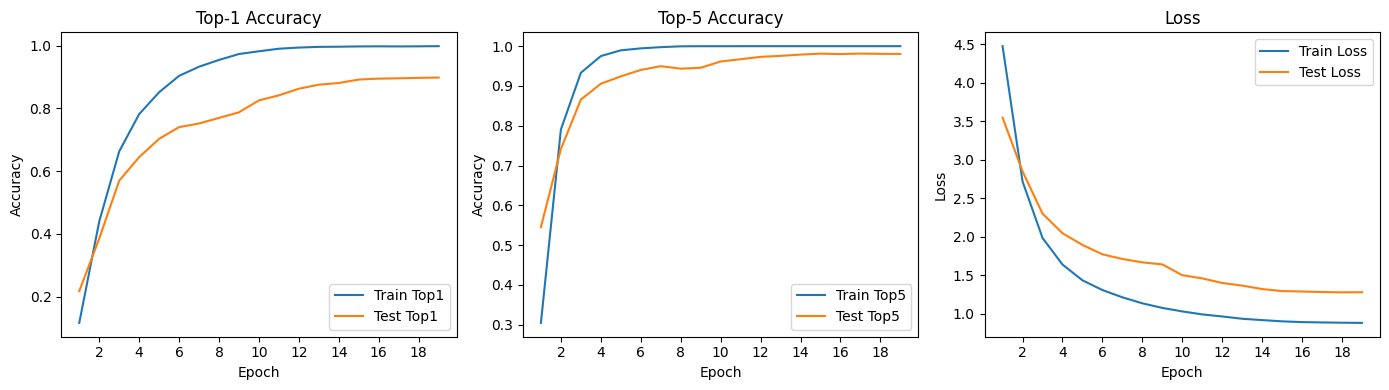


=== Plots: resnet101_320 ===


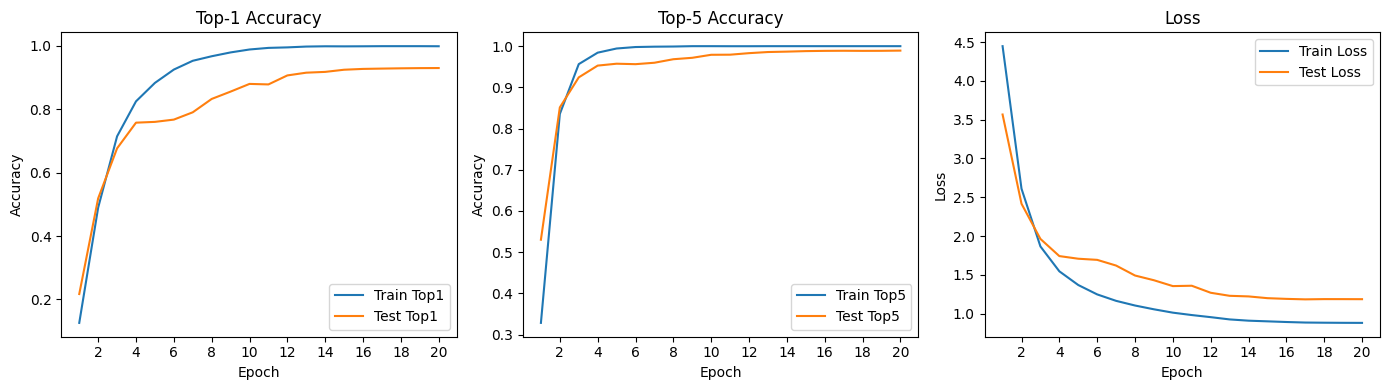

In [12]:
# Plot accuracy/loss for each model
from train_utils import plot_history
for s in summaries:
    print(f"\n=== Plots: {s['model']} ===")
    plot_history(s['history'])
